In [2]:
!pip install cupy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cupy
  Running setup.py clean for cupy
Failed to build cupy
ERROR: Could not build wheels for cupy, which is required to install pyproject.toml-based projects


Image Size: 225, Kernel Size: 3, CPU Time: 0.026301 seconds, GPU Time: 3.699340 seconds, Speedup: 0.01x
Image Size: 225, Kernel Size: 5, CPU Time: 0.000302 seconds, GPU Time: 0.624013 seconds, Speedup: 0.00x
Image Size: 225, Kernel Size: 7, CPU Time: 0.000382 seconds, GPU Time: 0.455710 seconds, Speedup: 0.00x
Image Size: 682, Kernel Size: 3, CPU Time: 0.000529 seconds, GPU Time: 0.000909 seconds, Speedup: 0.58x
Image Size: 682, Kernel Size: 5, CPU Time: 0.002006 seconds, GPU Time: 0.000851 seconds, Speedup: 2.36x
Image Size: 682, Kernel Size: 7, CPU Time: 0.003921 seconds, GPU Time: 0.000944 seconds, Speedup: 4.15x
Image Size: 1204, Kernel Size: 3, CPU Time: 0.001584 seconds, GPU Time: 0.003840 seconds, Speedup: 0.41x
Image Size: 1204, Kernel Size: 5, CPU Time: 0.006404 seconds, GPU Time: 0.002118 seconds, Speedup: 3.02x
Image Size: 1204, Kernel Size: 7, CPU Time: 0.012437 seconds, GPU Time: 0.003381 seconds, Speedup: 3.68x
Image Size: 2975, Kernel Size: 3, CPU Time: 0.004185 seconds,

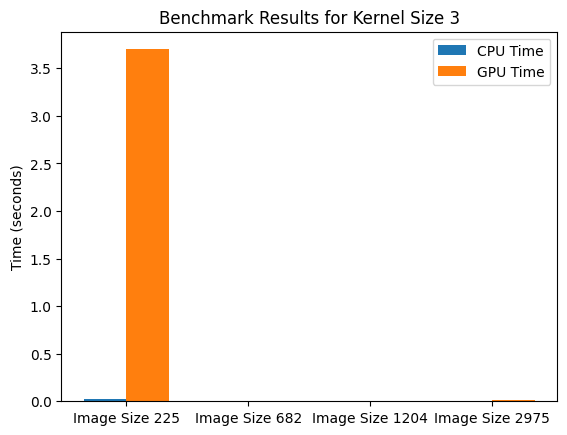

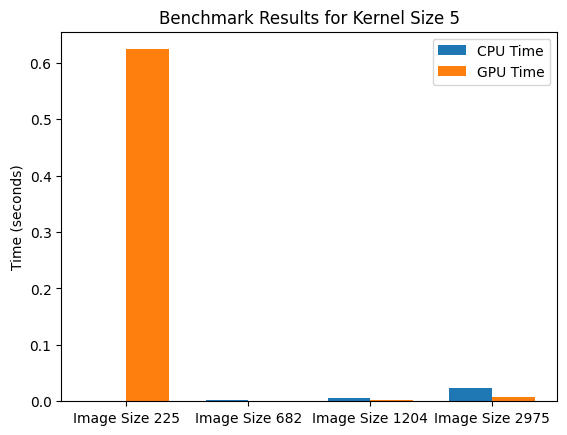

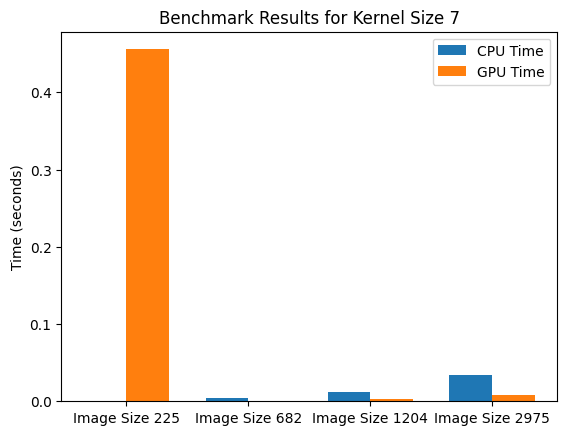

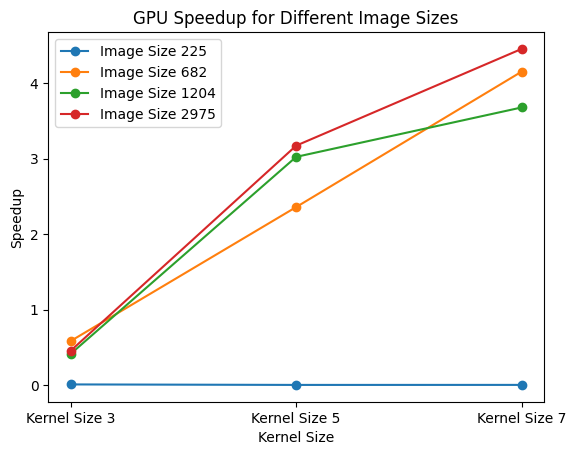

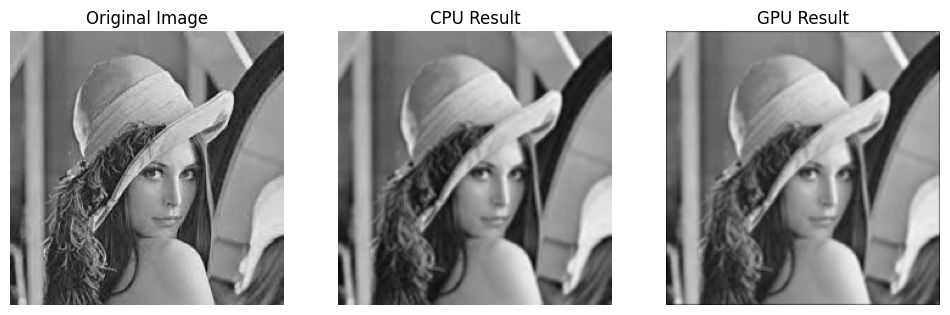

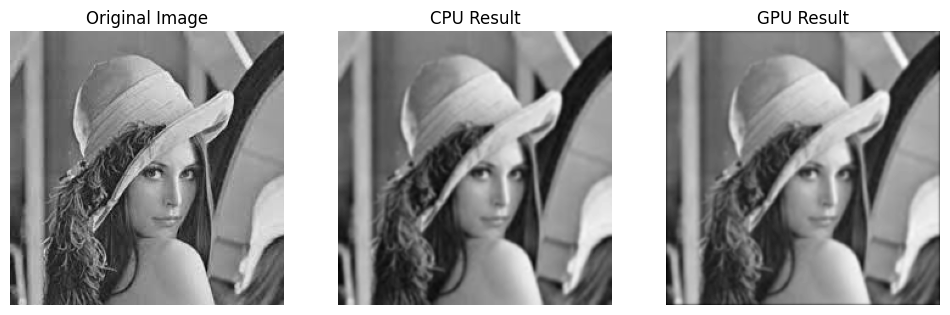

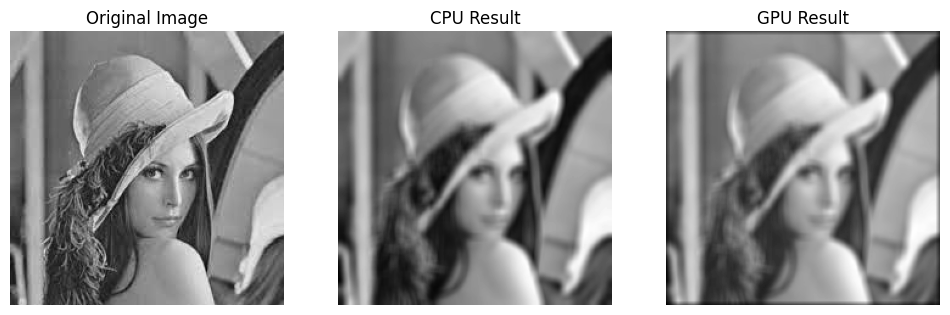

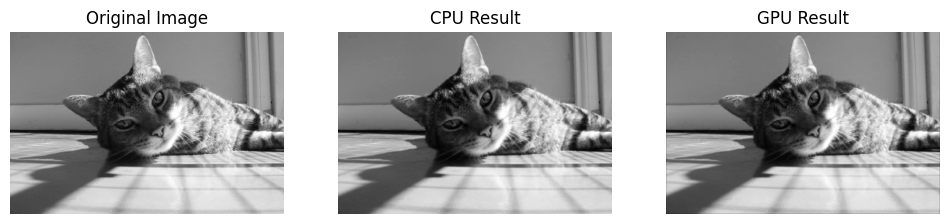

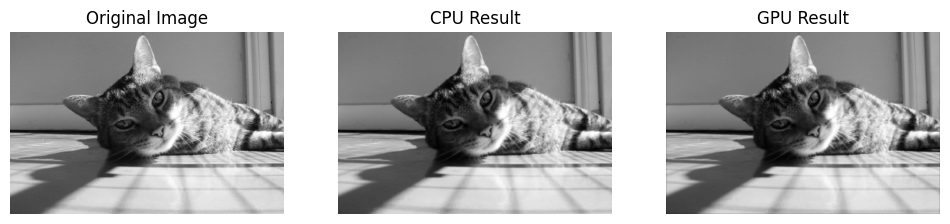

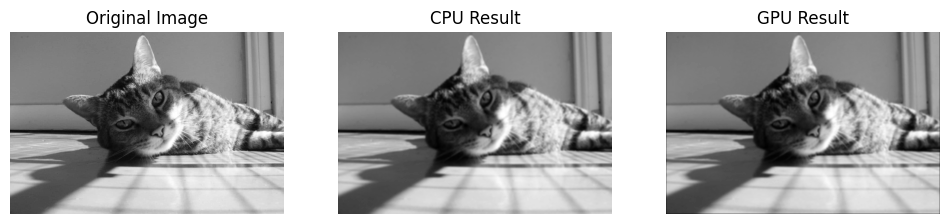

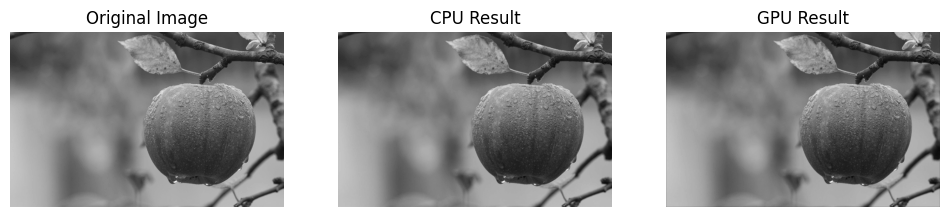

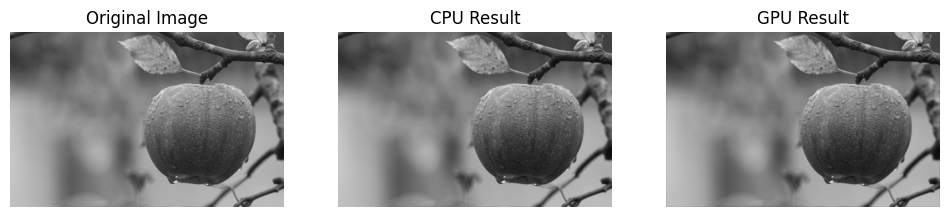

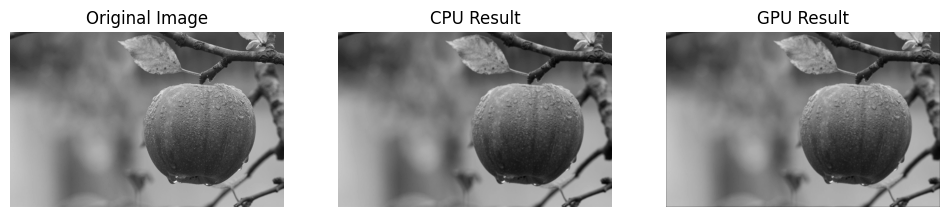

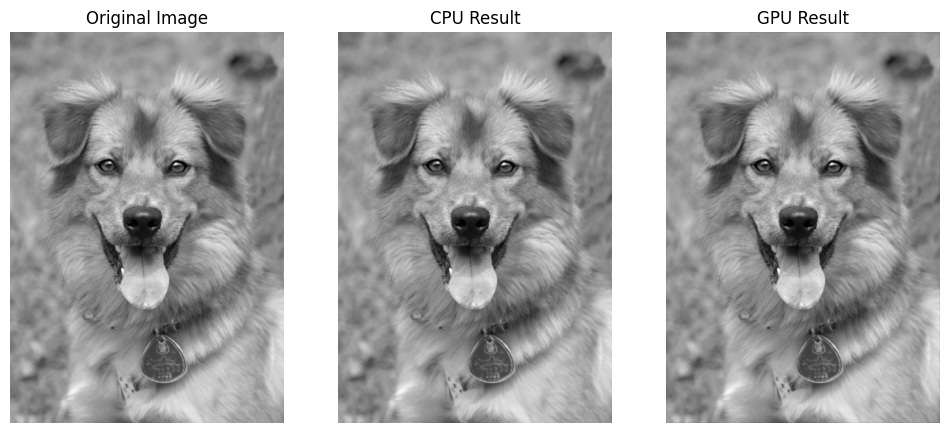

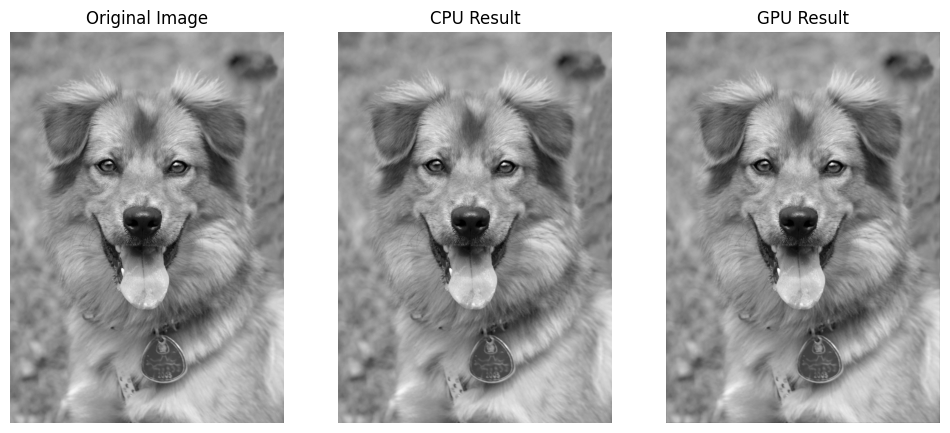

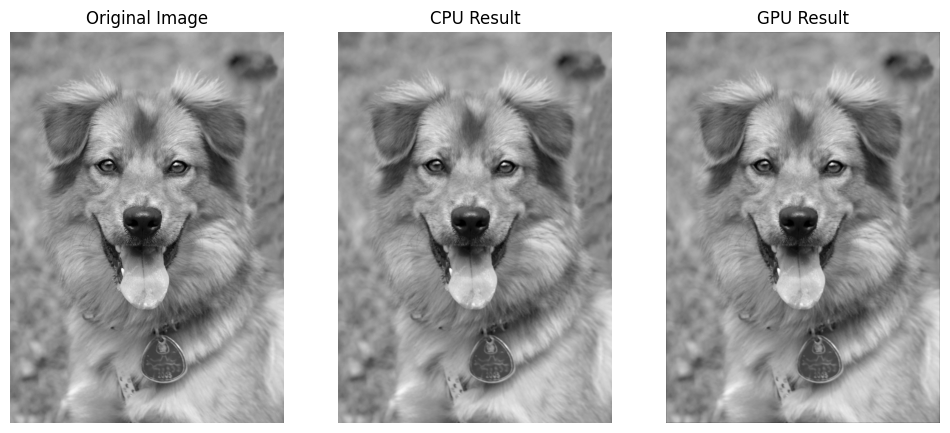

In [4]:
import time
import numpy as np
import cv2
import cupy as cp
import matplotlib.pyplot as plt
from cupyx.scipy.ndimage import convolve as cp_convolve2d

def cpu_convolution(image, kernel):
    return cv2.filter2D(image, -1, kernel)

def gpu_convolution(image, kernel):
    image_gpu = cp.asarray(image)
    kernel_gpu = cp.asarray(kernel)
    result_gpu = cp_convolve2d(image_gpu, kernel_gpu, mode='constant')
    return cp.asnumpy(result_gpu)

def measure_cpu_time(image, kernel):
    start_time = time.time()
    _ = cpu_convolution(image, kernel)
    return time.time() - start_time

# Modify the measure_gpu_time function
def measure_gpu_time(image, kernel):
    start_time = time.time()
    _ = gpu_convolution(image, kernel)
    cp.cuda.Stream.null.synchronize()  # Wait for GPU to finish
    return time.time() - start_time



def benchmarks(image_paths, kernels):
    results = []

    for image_path in image_paths:

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        for kernel_size, kernel in kernels.items():
            if kernel_size == 5:
              kernel = np.asarray(kernel) * (1 / 256)
            else:
              kernel = np.asarray(kernel) / (kernel_size * kernel_size)

            # Measure CPU time and perform CPU convolution
            cpu_time = measure_cpu_time(image, kernel)

            cpu_result = cpu_convolution(image, kernel)

            # Measure GPU time and perform GPU convolution
            gpu_time = measure_gpu_time(image, kernel)

            gpu_result = gpu_convolution(image, kernel)

            # Speedup calculation
            speedup = cpu_time / gpu_time

            results.append({
                'Image Size': image.shape[0],
                'Image Path': image_path,
                'Kernel Size': kernel_size,
                'CPU Time': cpu_time,
                'GPU Time': gpu_time,
                'Speedup': speedup,
                'Original Image': image,
                'CPU Result': cpu_result,
                'GPU Result': gpu_result
            })

    return results

def visualize_benchmarks(benchmark_results):
    # Visualize CPU and GPU times for different configurations
    for kernel_size in sorted(set(result['Kernel Size'] for result in benchmark_results)):
        cpu_times = [result['CPU Time'] for result in benchmark_results if result['Kernel Size'] == kernel_size]
        gpu_times = [result['GPU Time'] for result in benchmark_results if result['Kernel Size'] == kernel_size]

        labels = [f"Image Size {result['Image Size']}" for result in benchmark_results if result['Kernel Size'] == kernel_size]

        x = np.arange(len(labels))
        width = 0.35

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, cpu_times, width, label='CPU Time')
        rects2 = ax.bar(x + width/2, gpu_times, width, label='GPU Time')

        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Benchmark Results for Kernel Size {kernel_size}')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        plt.show()
        print("")

    # Visualize speedup for different configurations
    for image_size in sorted(set(result['Image Size'] for result in benchmark_results)):
        speedups = [result['Speedup'] for result in benchmark_results if result['Image Size'] == image_size]

        labels = [f"Kernel Size {result['Kernel Size']}" for result in benchmark_results if result['Image Size'] == image_size]

        plt.plot(labels, speedups, marker='o', label=f'Image Size {image_size}')

    plt.xlabel('Kernel Size')
    plt.ylabel('Speedup')
    plt.title('GPU Speedup for Different Image Sizes')
    plt.legend()
    plt.show()
    print("")

    for result in benchmark_results:
        # Display original image
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(result['Original Image'], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display CPU result
        plt.subplot(1, 3, 2)
        plt.imshow(result['CPU Result'], cmap='gray')
        plt.title('CPU Result')
        plt.axis('off')

        # Display GPU result
        plt.subplot(1, 3, 3)
        plt.imshow(result['GPU Result'], cmap='gray')
        plt.title('GPU Result')
        plt.axis('off')

        plt.show()
        print("")

def main():
    # Specify different image sizes and kernel sizes for benchmarking
    image_paths = ["/content/image.jpeg", "/content/cat.jpg", "/content/gray.jpg", "/content/happy_dog.jpg"]
    kernels = {3: [[1,0,1],[0,1,0],[1,0,1]], 5:[[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4, 6, 4, 1]],
                    7: [[1,1,1,1,1,1,1], [1,1,1,1,1,1,1], [1,1,1,1,1,1,1], [1,1,1,1,1,1,1], [1,1,1,1,1,1,1], [1,1,1,1,1,1,1], [1,1,1,1,1,1,1]]}

    # Run benchmarks
    benchmark_results = benchmarks(image_paths, kernels)

    # Print benchmark results
    for result in benchmark_results:
        print(f"Image Size: {result['Image Size']}, Kernel Size: {result['Kernel Size']}, "
              f"CPU Time: {result['CPU Time']:.6f} seconds, GPU Time: {result['GPU Time']:.6f} seconds, "
              f"Speedup: {result['Speedup']:.2f}x")

    print("")
    # Visualize benchmark results
    visualize_benchmarks(benchmark_results)

if __name__ == "__main__":
    main()
